In [24]:

from statistics import mean
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve as roc

In [16]:
# https://towardsdatascience.com/lstms-in-pytorch-528b0440244
# https://github.com/IHCA-Coding-to-Prevent-Coding/ML-SampleNeuralNet/blob/main/sampleneuralnet.py
# data from https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [17]:
data = pd.read_csv('Tetuan City power consumption.csv')
data.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [18]:
#first week of data is training, second week is testing

splitPoint = 144*7

trainTruth = data.iloc[:splitPoint, [6]]
training = data.iloc[:splitPoint, [1, 2, 3, 4, 5]]

testTruth = data.iloc[splitPoint:splitPoint*2, [6]]
testing = data.iloc[splitPoint:splitPoint*2, [1, 2, 3, 4, 5]]

trainTruth = torch.tensor(trainTruth.values)
training = torch.tensor(training.values)

testTruth = torch.tensor(testTruth.values)
testing = torch.tensor(testing.values)

training = training.float()
testing = testing.float()
trainTruth = trainTruth.float()
testTruth = testTruth.float()

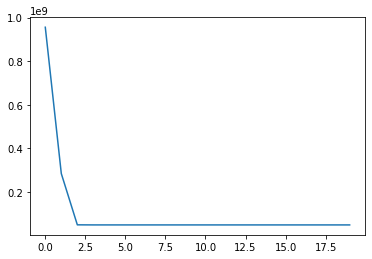

In [19]:
#testing = torch.randn(batchSize, seqLength, inputSize)

inputSize=5 # variables input
hiddenSize=16 # nodes of hidden layer
outSize=1 # power consumptoion in zone 1
batchSize= 144*7 # how many data points are in batch
lr = 0.1
seqLength=144 # num of time values per input
epochSize = 20

class extractTensor(nn.Module):
    def forward(self, x):
        tensor, hs = x
        return tensor.reshape(-1, hiddenSize) 

model = nn.Sequential(
    nn.LSTM(inputSize, hiddenSize),
    extractTensor(),
    nn.Linear(hiddenSize, outSize)
)

def lossFunc(data=training, comparison=trainTruth, model=model):
    prediction = model(data)

    MSEloss = torch.nn.MSELoss()
    output = MSEloss(prediction, comparison)
    
    return output, prediction

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

lossList = []
for i in range(epochSize):
    loss, output = lossFunc()
    lossList.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(lossList)
training_loss = loss.item();

In [22]:
with torch.no_grad():
    testing_loss, prediction = lossFunc(testing, testTruth);
    testing_loss = testing_loss.item()
   
    print(f"training loss:    {training_loss}");
    print(f"testing loss:     {testing_loss}");
    print(f"testing-training: {testing_loss-training_loss}");
    print(f"testing/training: {training_loss/testing_loss}");
    print(f"% error           {(testing_loss-training_loss)/testing_loss}");

training loss:    49520508.0
testing loss:     51566416.0
testing-training: 2045908.0
testing/training: 0.9603247974418079
% error           0.03967520255819214


In [ ]:
errorRange = mean(data['Zone 1 Power Consumption'])*.05
print(f"5% of zone 1 power usage mean: {errorRange}")

5% of zone 1 power usage mean: 1617.2485281792965


c:\Users\natha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1009: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


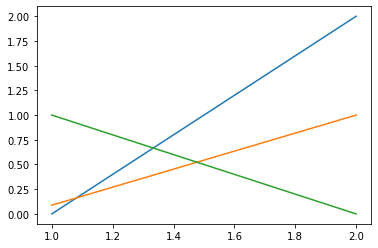

In [29]:
# use sklearn for auroc curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    # roc curve docs
    # integral of above is auroc
# need binary values for above
    # get from seeing if prediction is in error range of truth value
    # 5% of average power usage??


#assigning predictions to true or false based on error range

#TODO roc meant to use binary true/dalse values not continuous data
    #change data setup to binary prediction?
        # chance city will use more than average power??

isCorrect =[]
for i in range(len(prediction)):
    if (prediction[i] <= testTruth[i] + errorRange) and (prediction[i] >= testTruth[i] - errorRange):
        isCorrect.append(1)
    else:
        isCorrect.append(0)


plt.plot(roc([1]*len(isCorrect), isCorrect))
